#### **Human In The Loop - LangGraph**

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")

##### **1. How to wait for user input using interrupt**

In [2]:
# Set up the state
from langgraph.types import interrupt,Command
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {query}. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈."


tools = [search]
tool_node = ToolNode(tools)

# Set up the model
from langchain_groq import ChatGroq

model = ChatGroq(model_name="Gemma2-9b-It",temperature=0)

from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human` which is fake_tool
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    location = interrupt("Please provide your location:")
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory)

In [9]:
config = {"configurable": {"thread_id": "3"}}
response = app.invoke({"messages": [("user","Use the search tool to ask the user where they are, then look up the weather there",)]},config,stream_mode="values")
response

{'messages': [HumanMessage(content='Use the search tool to ask the user where they are, then look up the weather there', additional_kwargs={}, response_metadata={}, id='768b8e15-c5bd-45b4-b44a-7351126ef66b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qf49', 'function': {'arguments': '{"question":"Where are you located?"}', 'name': 'AskHuman'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1055, 'total_tokens': 1137, 'completion_time': 0.149090909, 'prompt_time': 0.043187565, 'queue_time': 0.05530389100000001, 'total_time': 0.192278474}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2c66538-5817-4f50-ac5f-a1ecf71b0972-0', tool_calls=[{'name': 'AskHuman', 'args': {'question': 'Where are you located?'}, 'id': 'call_qf49', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1055, 'output_tokens': 82, 'total_tokens': 1137})]}

In [10]:
response["messages"]

[HumanMessage(content='Use the search tool to ask the user where they are, then look up the weather there', additional_kwargs={}, response_metadata={}, id='768b8e15-c5bd-45b4-b44a-7351126ef66b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qf49', 'function': {'arguments': '{"question":"Where are you located?"}', 'name': 'AskHuman'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1055, 'total_tokens': 1137, 'completion_time': 0.149090909, 'prompt_time': 0.043187565, 'queue_time': 0.05530389100000001, 'total_time': 0.192278474}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2c66538-5817-4f50-ac5f-a1ecf71b0972-0', tool_calls=[{'name': 'AskHuman', 'args': {'question': 'Where are you located?'}, 'id': 'call_qf49', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1055, 'output_tokens': 82, 'total_tokens': 1137})]

In [11]:
app.get_state(config).next

('ask_human',)

In [12]:
response = app.invoke(Command(resume="San Francisco"),config,stream_mode="values")
response

{'messages': [HumanMessage(content='Use the search tool to ask the user where they are, then look up the weather there', additional_kwargs={}, response_metadata={}, id='768b8e15-c5bd-45b4-b44a-7351126ef66b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qf49', 'function': {'arguments': '{"question":"Where are you located?"}', 'name': 'AskHuman'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1055, 'total_tokens': 1137, 'completion_time': 0.149090909, 'prompt_time': 0.043187565, 'queue_time': 0.05530389100000001, 'total_time': 0.192278474}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d2c66538-5817-4f50-ac5f-a1ecf71b0972-0', tool_calls=[{'name': 'AskHuman', 'args': {'question': 'Where are you located?'}, 'id': 'call_qf49', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1055, 'output_tokens': 82, 'total_tokens': 1137}),


In [13]:
config = {"configurable": {"thread_id": "test"}}
response = app.invoke({"messages": [("user","What is the weather in Pune ?",)]},config,stream_mode="values")
response

{'messages': [HumanMessage(content='What is the weather in Pune ?', additional_kwargs={}, response_metadata={}, id='de29c8f1-aa81-417f-b744-3e5574be68d3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x84x', 'function': {'arguments': '{"query":"weather in Pune"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1044, 'total_tokens': 1126, 'completion_time': 0.149090909, 'prompt_time': 0.033608736, 'queue_time': 0.054508256000000005, 'total_time': 0.182699645}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ef6c4476-ff1a-4ce8-bc29-94fc2ca7a2ac-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Pune'}, 'id': 'call_x84x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1044, 'output_tokens': 82, 'total_tokens': 1126}),
  ToolMessage(content="I looked up: weather in Pune. Result: It's sunny in S

##### **2. How to review tool calls**

First, we will have an LLM call that decides what action to take. Then we go to a human node. This node actually doesn't do anything - the idea is that we interrupt before this node and then apply any updates to the state. After that, we check the state and either route back to the LLM or to the correct tool.

In [7]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from langchain_groq import ChatGroq
from langchain_openai import AzureChatOpenAI

@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"


# model = ChatGroq(model_name="gemma2-9b-it",temperature=0.2).bind_tools(
#     [weather_search]
# )
model = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",  # or your deployment
    api_version="2024-08-01-preview",  # or your api version
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
model = model.bind_tools([weather_search])

class State(MessagesState):
    """Simple state."""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

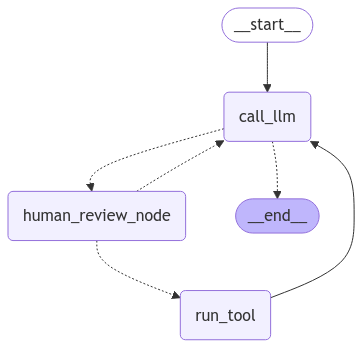

In [8]:
graph

In [9]:
initial_input = {"messages": [{"role": "user", "content": "hi!"}]}

# Thread
thread = {"configurable": {"thread_id": "hrishi-latest"}}

graph.invoke(initial_input,config=thread)

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='2c7c4a3e-6e87-4918-a631-4cfeae435fb1'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 46, 'total_tokens': 56, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_m

##### Action : Not Required

In [10]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='2c7c4a3e-6e87-4918-a631-4cfeae435fb1'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 46, 'total_tokens': 56, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': F

In [ ]:
# here the execution has been completed so there is no next state
graph.get_state(thread).next

()

##### Action : Continue

In [14]:
initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "hrishi4"}}

response = graph.invoke(initial_input,config=thread)

In [15]:
response["messages"][-1].tool_calls

[{'name': 'weather_search',
  'args': {'city': 'San Francisco'},
  'id': 'call_MAiKmoOMm7L4oEQCTKOGi8Rd',
  'type': 'tool_call'}]

In [17]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='aa314d19-1914-47af-a6e2-cb4a20708981'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MAiKmoOMm7L4oEQCTKOGi8Rd', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_cal

In [16]:
graph.get_state(thread).next

('human_review_node',)

In [18]:
graph.invoke(Command(resume={"action":"continue"}),config=thread)

----
Searching for: San Francisco
----


{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='aa314d19-1914-47af-a6e2-cb4a20708981'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MAiKmoOMm7L4oEQCTKOGi8Rd', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': No

In [19]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='aa314d19-1914-47af-a6e2-cb4a20708981'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MAiKmoOMm7L4oEQCTKOGi8Rd', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_cal

In [20]:
graph.get_state(thread).next

()

##### Action : feedback

In [21]:
initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "hrishi5"}}

response = graph.invoke(initial_input,config=thread)

In [29]:
graph.get_state(thread).values['messages']

[HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='a46f615b-d4bd-4b34-bdaa-956a069aa087'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zeiT3Pb5vwBgXoMzt3Ywg6hO', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_f

In [30]:
graph.get_state(thread).next

('human_review_node',)

In [34]:
# providing the feedback through Command 
response = graph.invoke(Command(resume={'action':'feedback','data':'User requested changes: use <city, country> format for location'}),config=thread)
response

{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='a46f615b-d4bd-4b34-bdaa-956a069aa087'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zeiT3Pb5vwBgXoMzt3Ywg6hO', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': No

In [36]:
graph.get_state(thread).values

{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='a46f615b-d4bd-4b34-bdaa-956a069aa087'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zeiT3Pb5vwBgXoMzt3Ywg6hO', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': No

In [37]:
graph.get_state(thread).next

('human_review_node',)

In [38]:
response = graph.invoke(Command(resume={'action':'continue'}),config=thread)

----
Searching for: San Francisco, US
----


In [39]:
response

{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='a46f615b-d4bd-4b34-bdaa-956a069aa087'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zeiT3Pb5vwBgXoMzt3Ywg6hO', 'function': {'arguments': '{\n  "city": "San Francisco"\n}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': No